In [27]:
import tensorflow as tf
import flax
from flax.training import checkpoints
from flax import jax_utils as flax_utils
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp

import functools


from models import super_simple
from models import utils as mutils
import sampling
import losses

from configs.ve.disk_ssim import get_config
import sde_lib
import datasets

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider

In [2]:
rng = jax.random.PRNGKey(42)
model_rng, sampling_rng = jax.random.split(rng)
config = get_config()
score_model, init_model_state, init_model_params = mutils.init_model(model_rng, config)

In [13]:
optimizer = losses.get_optimizer(config).create(init_model_params)

state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                       model_state=init_model_state,
                       ema_rate=config.model.ema_rate,
                       params_ema=init_model_params,
                       rng=rng)

In [14]:
ckpt_model_state = checkpoints.restore_checkpoint('checkpoints', state, 1)

In [15]:
if config.training.sde.lower() == 'vpsde':
    sde = sde_lib.VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    sampling_eps = 1e-3
elif config.training.sde.lower() == 'subvpsde':
    sde = sde_lib.subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    sampling_eps = 1e-3
elif config.training.sde.lower() == 'vesde':
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-5
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")
inverse_scaler = datasets.get_data_inverse_scaler(config)

sampling_shape = (config.training.batch_size // jax.local_device_count(), config.data.image_size,
                config.data.image_size, config.data.num_channels)

In [76]:
sde.N = 2000

In [77]:
# sampling_fn = pc_sampler
sampling_fn = sampling.get_sampling_fn(config, sde, score_model, sampling_shape, inverse_scaler, sampling_eps)

In [78]:
pstate = flax_utils.replicate(state)
num_train_steps = config.training.n_iters

# In case there are multiple hosts (e.g., TPU pods), only log to host 0
rng = jax.random.fold_in(rng, jax.host_id())
rng, *next_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
next_rng = jnp.asarray(next_rng)

a, b = sampling_fn(next_rng, pstate)

In [79]:
a_sq = jnp.squeeze(a)
a_sq.shape

(64, 2)

In [80]:
jnp.sum(a_sq**2, axis=1).mean()

DeviceArray(3.1743815e+29, dtype=float32)

In [23]:
def pc_sampler(rng, state):
    """ The PC sampler funciton.

    Args:
      rng: A JAX random state
      state: A `flax.struct.dataclass` object that represents the training state of a score-based model.
    Returns:
      Samples, number of function evaluations
    """
    # Initial sample
    predictor_update_fn = functools.partial(sampling.shared_predictor_update_fn,
                                          sde=sde,
                                          model=score_model,
                                          predictor=config.sampling.predictor,
                                          probability_flow=config.sampling.probability_flow,
                                          continuous=config.training.continuous)
    corrector_update_fn = functools.partial(sampling.shared_corrector_update_fn,
                                          sde=sde,
                                          model=score_model,
                                          corrector=config.sampling.corrector,
                                          continuous=config.training.continuous,
                                          snr=config.sampling.snr,
                                          n_steps=config.sampling.n_steps_each)
    rng, step_rng = jax.random.split(rng)
    x = sde.prior_sampling(step_rng, sampling_shape)
    timesteps = jnp.linspace(sde.T, sampling_eps, sde.N)

    def loop_body(i, val):
      rng, x, x_mean = val
      t = timesteps[i]
      vec_t = jnp.ones(sampling_shape[0]) * t
      rng, step_rng = jax.random.split(rng)
      x, x_mean = corrector_update_fn(step_rng, state, x, vec_t)
      rng, step_rng = jax.random.split(rng)
      x, x_mean = predictor_update_fn(step_rng, state, x, vec_t)
      return rng, x, x_mean

    _, x, x_mean = jax.lax.fori_loop(0, sde.N, loop_body, (rng, x, x))
    # Denoising is equivalent to running one predictor step without adding noise.
    return inverse_scaler(x_mean if config.sampling.noise_removal else x), sde.N * (config.sampling.n_steps_each + 1)

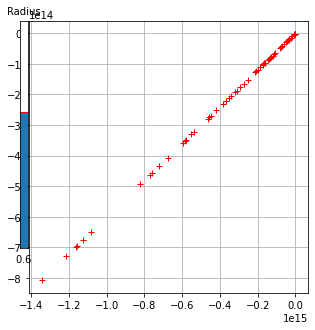

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)

circle = plt.Circle((0, 0), 1, color='r', fill=False)

xs = lambda r: a_sq[:, 0]
ys = lambda r: a_sq[:, 1]

ax.add_patch(circle)
line, = ax.plot(xs(0.6), ys(0.6), 'r+')
ax.grid(True)

ax.plot(jnp.linspace(-1.4e15, 1e15))

axrad = fig.add_axes([0.1, 0.25, 0.0225, 0.63])

rad_slider = Slider(
    ax=axrad,
    label="Radius",
    valmin=0.,
    valmax=1.,
    valinit=0.6,
    orientation="vertical"
)

def update(val):
    line.set_ydata(ys(rad_slider.val))
    line.set_xdata(xs(rad_slider.val))
    fig.canvas.draw_idle()


rad_slider.on_changed(update)

plt.show()